# KNN models

Here we attempt to use K-Nearest Neighbour models to try and predict the Microsoft share price.

In [1]:
#The usual imports

import yfinance as yf
import os
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import precision_score

C:\Users\Ben Fairbairn\anaconda3NEW\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Downloading the data

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

C:\Users\Ben Fairbairn\anaconda3NEW\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [3]:
#Quick inspection of the data

msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.054792,0.062849,0.054792,0.060163,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060163,0.063386,0.060163,0.062311,308160000,0.0,0.0
1986-03-17 05:00:00,0.062311,0.063923,0.062311,0.063386,133171200,0.0,0.0
1986-03-18 05:00:00,0.063386,0.063923,0.061237,0.061774,67766400,0.0,0.0
1986-03-19 05:00:00,0.061774,0.062311,0.060163,0.060700,47894400,0.0,0.0


<Axes: >

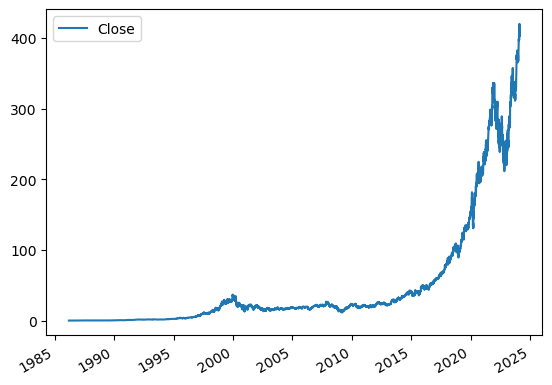

In [4]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [5]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [6]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [7]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

## $K=5$

In [10]:
# Create a KNN classification model.  Set min_samples_split high to ensure we don't overfit.
model = KNeighborsClassifier(n_neighbors=5)

In [11]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

KNeighborsClassifier()

In [12]:
# Evaluate error of predictions 
preds = model.predict(test[predictors]) 
preds = pd.Series(preds, index=test.index) 
precision_score(test["Target"], preds)

0.6153846153846154

In [13]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [14]:
predictions = backtest(data, model, predictors)

In [15]:
# Calculate the precision of the model

precision_score(predictions["Target"], predictions["Predictions"])

0.5027223230490018

In [16]:
# Calculate some rolling means to help improve accuracy

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [17]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [18]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [19]:
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_trend"] = weekly_trend

In [20]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [21]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]


In [22]:
# Removing the first year's data to avoid the NaNs we've just created

predictions = backtest(data.iloc[365:], model, full_predictors)

In [23]:
# Hopefully improved precision 

precision_score(predictions["Target"], predictions["Predictions"])

0.5031055900621118

In [24]:
# Show how many trades we would make 
predictions["Predictions"].value_counts()

Predictions
0.0    6585
1.0    1610
Name: count, dtype: int64

## $K=11$

In [25]:
# Create a KNN classification model.  Set min_samples_split high to ensure we don't overfit.
model = KNeighborsClassifier(n_neighbors=11)

In [26]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

KNeighborsClassifier(n_neighbors=11)

In [27]:
# Evaluate error of predictions 
preds = model.predict(test[predictors]) 
preds = pd.Series(preds, index=test.index) 
precision_score(test["Target"], preds)

0.6363636363636364

In [28]:
predictions = backtest(data, model, predictors)

In [29]:
# Calculate the precision of the model

precision_score(predictions["Target"], predictions["Predictions"])

0.5082036180058898

In [30]:
# Removing the first year's data to avoid the NaNs we've just created

predictions = backtest(data.iloc[365:], model, full_predictors)

In [31]:
# Hopefully improved precision 

precision_score(predictions["Target"], predictions["Predictions"])

0.5056461731493099

In [32]:
# Show how many trades we would make 
predictions["Predictions"].value_counts()

Predictions
0.0    5804
1.0    2391
Name: count, dtype: int64